In [1]:
import logging
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
from hmmlearn.hmm import GMMHMM
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
class HpcPredictor(object):
    def __init__(self, file_name, latency = 3, test_size = 0.33, n_hidden_states = 7, n_mix = 2, 
                 n_steps_A = 8, n_steps_B = 8, n_steps_C = 8, n_steps_total_change = 16):
        
        self._init_logger()
        self.latency = latency
        self.split_train_test_data(file_name, test_size)
        #self.hmm = GMMHMM(n_components=n_hidden_states, n_mix=n_mix)
        self.hmm = GaussianHMM(n_components=n_hidden_states)
        self._compute_all_possible_outcomes(n_steps_A, n_steps_B, n_steps_C, n_steps_total_change)
    
    def _init_logger(self):
        self._logger = logging.getLogger(__name__)
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
        handler.setFormatter(formatter)
        self._logger.addHandler(handler)
        self._logger.setLevel(logging.DEBUG)
    
    def split_train_test_data(self, file_name, test_size):
        data = pd.read_csv(file_name)
        data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
        train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)
        self.train_data = train_data
        self.test_data = test_data
    
    def _extract_features(data):        
        # write featrue
        feature_A = np.array(data['cpu/ref-cycles/_change'])
        feature_B = np.array(data['timer:hrtimer_cancel_change'])
        feature_C = np.array(data['sched:sched_stat_runtime_change'])
        total_change = np.array(data['total_change'])
        
        return np.column_stack((feature_A, feature_B, feature_C, total_change))
        
    def fit(self):
        self._logger.info('>>> Extracting Features')
        feature_vactor = HpcPredictor._extract_features(self.train_data)
        self._logger.info('Features extraction Completed <<<')
        self.hmm.fit(feature_vactor)
        
    def _compute_all_possible_outcomes(self, n_steps_A, n_steps_B, n_steps_C, n_steps_total_change):
        feature_A_range = np.linspace(-0.3, 0.5, n_steps_A)
        feature_B_range = np.linspace(-0.3, 0.5, n_steps_B)
        feature_C_range = np.linspace(-0.3, 0.5, n_steps_C)
        total_change_range = np.linspace(-0.3, 0.5, n_steps_total_change)
        
        self._possible_outcomes = np.array(list(itertools.product(feature_A_range, feature_B_range, 
                                                                  feature_C_range, total_change_range)))
        
    def _get_most_probable_outcome(self, index):
        previous_data_start_index = max(0, index - self.latency)
        previous_data_end_index = max(0, index) # ARRAY SLICE RANGE
        previous_data = self.test_data.iloc[previous_data_start_index : previous_data_end_index]
        previous_data_features = HpcPredictor._extract_features(previous_data)
             
        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack((previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))
        
        most_probable_outcome = self._possible_outcomes[np.argmax(outcome_score)]
        return most_probable_outcome
    
    def predict_close_power(self, index):
        
        total_power = self.test_data.iloc[index]['pre_total']
        _, _, _, predicted_total_change = self._get_most_probable_outcome(index)
        return total_power * (1 + predicted_total_change)
    
    def predict_close_change(self, index):
        
        _, _, _, predicted_total_change = self._get_most_probable_outcome(index)
        return predicted_total_change
    
    def predict_close_power_time(self, times, with_plot=False):
        predicted_close_power = []
        for index in tqdm(range(times)):
            predicted_close_power.append(self.predict_close_power(index))
        
        if with_plot:
            test_data = self.test_data[0:times]
            times = np.array(test_data['Unnamed: 0'])
            actual_total = test_data['total']
            
            fig = plt.figure(figsize=(10,8))
            
            axes = fig.add_subplot(111)
            axes.plot(times, actual_total, 'bo-', label='actual')
            axes.plot(times, predicted_close_power, 'r+-', label='predicted')
            
            plt.legend()
            plt.show()
            
        return predicted_close_power
    
    def predict_change_time(self, times, with_plot=False):
        predicted_change = []
        for index in tqdm(range(times)):
            predicted_change.append(self.predict_close_change(index))
            test_pr = self.predict_close_change(index+1)
            
        if with_plot:
            test_data = self.test_data[0:times]
            times = np.array(test_data['Unnamed: 0'])
            actual_total = test_data['total_change']
            
            mape = mean_absolute_percentage_error(actual_total, predicted_change)
            
            fig = plt.figure(figsize=(15,8))
            
            axes = fig.add_subplot(111)
            axes.plot(times, actual_total, 'bo-', label='actual')
            axes.plot(times, predicted_change, 'r+-', label='predicted')
            
            plt.legend()
            plt.show()
            print(mape)
            
        #return predicted_change
        return None

2020-05-11 18:33:13,401 __main__     INFO     >>> Extracting Features
2020-05-11 18:33:13,401 __main__     INFO     >>> Extracting Features
2020-05-11 18:33:13,402 __main__     INFO     Features extraction Completed <<<
2020-05-11 18:33:13,402 __main__     INFO     Features extraction Completed <<<
100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:25<00:00,  3.41s/it]


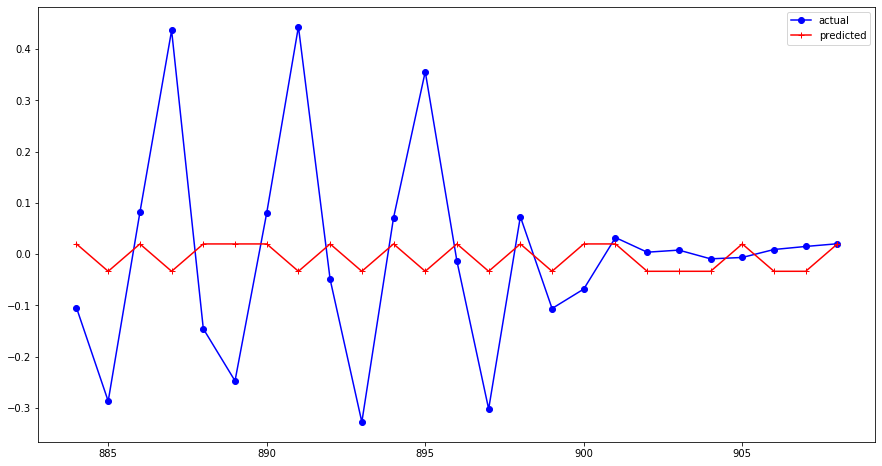

191.8039377300565


In [6]:
hpc = HpcPredictor('../원본 데이터/test_data/total_low_30_8_change.csv')
hpc.fit()
#hpc.predict_close_power_time(20, with_plot=True)
hpc.predict_change_time(25, with_plot=True)

2020-05-11 18:21:46,795 __main__     INFO     >>> Extracting Features
2020-05-11 18:21:46,798 __main__     INFO     Features extraction Completed <<<
100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:23<00:00,  3.34s/it]


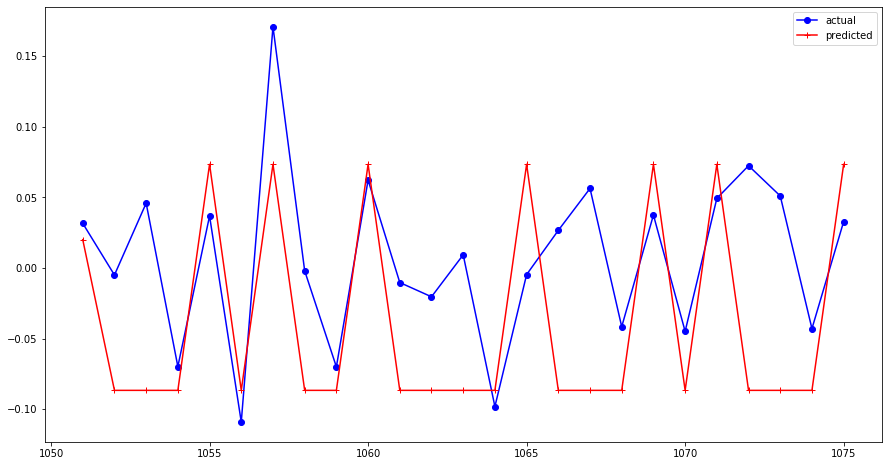

470.56400837362116


In [4]:
hpc = HpcPredictor('../원본 데이터/test_data/total_high_30_8_change.csv')
hpc.fit()
#hpc.predict_close_power_time(20, with_plot=True)
hpc.predict_change_time(25, with_plot=True)

2020-05-11 18:36:28,760 __main__     INFO     >>> Extracting Features
2020-05-11 18:36:28,760 __main__     INFO     >>> Extracting Features
2020-05-11 18:36:28,760 __main__     INFO     >>> Extracting Features
2020-05-11 18:36:28,762 __main__     INFO     Features extraction Completed <<<
2020-05-11 18:36:28,762 __main__     INFO     Features extraction Completed <<<
2020-05-11 18:36:28,762 __main__     INFO     Features extraction Completed <<<
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:40<00:00,  3.41s/it]


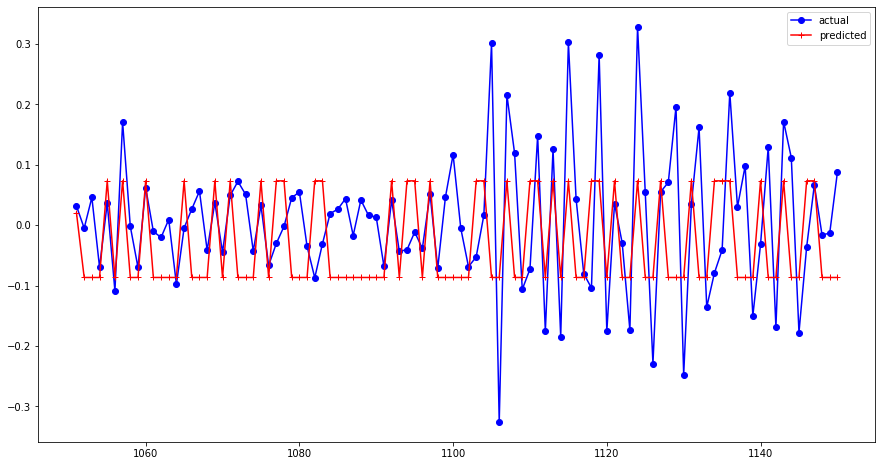

309.3426975251821


In [7]:
hpc = HpcPredictor('../원본 데이터/test_data/total_high_30_8_change.csv')
hpc.fit()
#hpc.predict_close_power_time(20, with_plot=True)
hpc.predict_change_time(100, with_plot=True)

2020-05-11 18:51:27,026 __main__     INFO     >>> Extracting Features
2020-05-11 18:51:27,026 __main__     INFO     >>> Extracting Features
2020-05-11 18:51:27,026 __main__     INFO     >>> Extracting Features
2020-05-11 18:51:27,026 __main__     INFO     >>> Extracting Features
2020-05-11 18:51:27,026 __main__     INFO     >>> Extracting Features
2020-05-11 18:51:27,029 __main__     INFO     Features extraction Completed <<<
2020-05-11 18:51:27,029 __main__     INFO     Features extraction Completed <<<
2020-05-11 18:51:27,029 __main__     INFO     Features extraction Completed <<<
2020-05-11 18:51:27,029 __main__     INFO     Features extraction Completed <<<
2020-05-11 18:51:27,029 __main__     INFO     Features extraction Completed <<<
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:44<00:00,  3.44s/it]


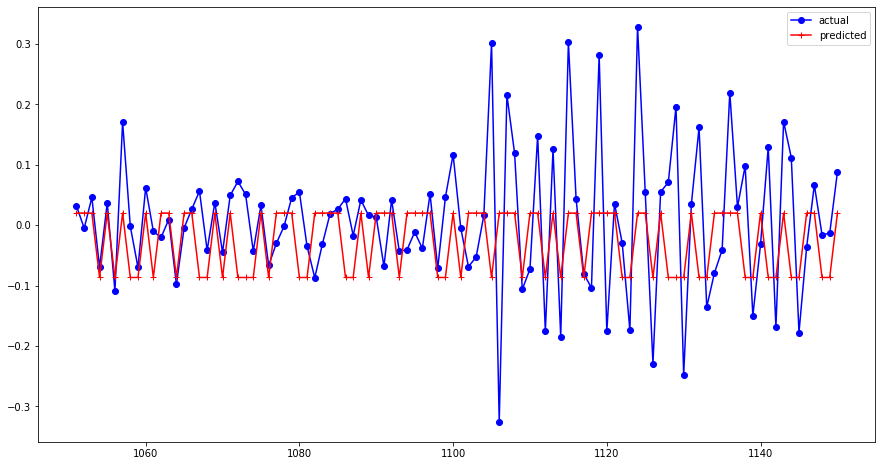

194.8851487465167


In [11]:
hpc = HpcPredictor('../원본 데이터/test_data/total_high_30_8_change.csv')
hpc.fit()
#hpc.predict_close_power_time(20, with_plot=True)
hpc.predict_change_time(100, with_plot=True)

2020-05-11 18:59:09,147 __main__     INFO     >>> Extracting Features
2020-05-11 18:59:09,147 __main__     INFO     >>> Extracting Features
2020-05-11 18:59:09,147 __main__     INFO     >>> Extracting Features
2020-05-11 18:59:09,147 __main__     INFO     >>> Extracting Features
2020-05-11 18:59:09,147 __main__     INFO     >>> Extracting Features
2020-05-11 18:59:09,147 __main__     INFO     >>> Extracting Features
2020-05-11 18:59:09,150 __main__     INFO     Features extraction Completed <<<
2020-05-11 18:59:09,150 __main__     INFO     Features extraction Completed <<<
2020-05-11 18:59:09,150 __main__     INFO     Features extraction Completed <<<
2020-05-11 18:59:09,150 __main__     INFO     Features extraction Completed <<<
2020-05-11 18:59:09,150 __main__     INFO     Features extraction Completed <<<
2020-05-11 18:59:09,150 __main__     INFO     Features extraction Completed <<<
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:4

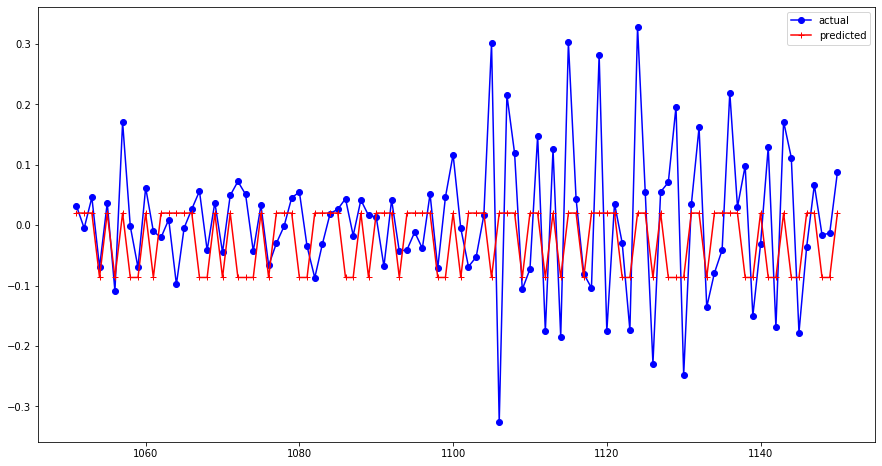

195.31259822558897


In [13]:
hpc = HpcPredictor('../원본 데이터/test_data/total_high_30_8_change.csv')
hpc.fit()
#hpc.predict_close_power_time(20, with_plot=True)
hpc.predict_change_time(100, with_plot=True)

In [6]:
class HpcPredictor(object):
    def __init__(self, file_name, latency = 4, test_size = 0.33, n_hidden_states = 7, n_mix = 2, 
                 n_steps_A = 20, n_steps_B = 20, n_steps_C = 20, n_steps_total_change = 20):
        
        self._init_logger()
        self.latency = latency
        #self.split_train_test_data(file_name, test_size)
        
        data = pd.read_csv(file_name)
        data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
        self.train_data = data
        data_t = pd.read_csv('../원본 데이터/test_data/15_high.csv')
        data_t = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
        self.test_data = data_t
        
        #self.hmm = GMMHMM(n_components=n_hidden_states, n_mix=n_mix)
        self.hmm = GaussianHMM(n_components=n_hidden_states)
        self._compute_all_possible_outcomes(n_steps_A, n_steps_B, n_steps_C, n_steps_total_change)
    
    def _init_logger(self):
        self._logger = logging.getLogger(__name__)
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
        handler.setFormatter(formatter)
        self._logger.addHandler(handler)
        self._logger.setLevel(logging.DEBUG)
    
    def split_train_test_data(self, file_name, test_size):
        data = pd.read_csv(file_name)
        data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
        train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)
        self.train_data = train_data
        self.test_data = test_data
    
    def _extract_features(data):        
        # write featrue
        feature_A = np.array(data['cpu/ref-cycles/_change'])
        feature_B = np.array(data['timer:hrtimer_cancel_change'])
        feature_C = np.array(data['sched:sched_stat_runtime_change'])
        total_change = np.array(data['total_change'])
        
        return np.column_stack((feature_A, feature_B, feature_C, total_change))
        
    def fit(self):
        self._logger.info('>>> Extracting Features')
        feature_vactor = HpcPredictor._extract_features(self.train_data)
        self._logger.info('Features extraction Completed <<<')
        self.hmm.fit(feature_vactor)
        
    def _compute_all_possible_outcomes(self, n_steps_A, n_steps_B, n_steps_C, n_steps_total_change):
        feature_A_range = np.linspace(-0.1, 0.1, n_steps_A)
        feature_B_range = np.linspace(-0.1, 0.1, n_steps_B)
        feature_C_range = np.linspace(-0.1, 0.1, n_steps_C)
        total_change_range = np.linspace(-0.05, 0.05, n_steps_total_change)
        
        self._possible_outcomes = np.array(list(itertools.product(feature_A_range, feature_B_range, 
                                                                  feature_C_range, total_change_range)))
        
    def _get_most_probable_outcome(self, index):
        previous_data_start_index = max(0, index - self.latency)
        previous_data_end_index = max(0, index) # ARRAY SLICE RANGE
        previous_data = self.test_data.iloc[previous_data_start_index : previous_data_end_index]
        previous_data_features = HpcPredictor._extract_features(previous_data)
             
        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack((previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))
        
        most_probable_outcome = self._possible_outcomes[np.argmax(outcome_score)]
        return most_probable_outcome
    
    def predict_close_power(self, index):
        
        total_power = self.test_data.iloc[index]['pre_total']
        _, _, _, predicted_total_change = self._get_most_probable_outcome(index)
        return total_power * (1 + predicted_total_change)
    
    def predict_close_change(self, index):
        
        _, _, _, predicted_total_change = self._get_most_probable_outcome(index)
        return predicted_total_change
    
    def predict_close_power_time(self, times, with_plot=False):
        predicted_close_power = []
        for index in tqdm(range(times)):
            predicted_close_power.append(self.predict_close_power(index))
        
        if with_plot:
            test_data = self.test_data[0:times]
            times = np.array(test_data['Unnamed: 0'])
            actual_total = test_data['total']
            
            fig = plt.figure(figsize=(10,8))
            
            axes = fig.add_subplot(111)
            axes.plot(times, actual_total, 'bo-', label='actual')
            axes.plot(times, predicted_close_power, 'r+-', label='predicted')
            
            plt.legend()
            plt.show()
            
        return predicted_close_power
    
    def predict_change_time(self, times, with_plot=False):
        predicted_change = []
        for index in tqdm(range(times)):
            predicted_change.append(self.predict_close_change(index))
            test_pr = self.predict_close_change(index+1)
            
        if with_plot:
            test_data = self.test_data[0:times]
            times = np.array(test_data['Unnamed: 0'])
            actual_total = test_data['total_change']
            
            mape = mean_absolute_percentage_error(actual_total, predicted_change)
            
            fig = plt.figure(figsize=(15,8))
            
            axes = fig.add_subplot(111)
            axes.plot(times, actual_total, 'bo-', label='actual')
            axes.plot(times, predicted_change, 'r+-', label='predicted')
            
            plt.legend()
            plt.show()
            print(mape)
            
        #return predicted_change
        return None

2020-05-12 13:02:08,443 __main__     INFO     >>> Extracting Features
2020-05-12 13:02:08,443 __main__     INFO     >>> Extracting Features
2020-05-12 13:02:08,443 __main__     INFO     >>> Extracting Features
2020-05-12 13:02:08,443 __main__     INFO     >>> Extracting Features
2020-05-12 13:02:08,445 __main__     INFO     Features extraction Completed <<<
2020-05-12 13:02:08,445 __main__     INFO     Features extraction Completed <<<
2020-05-12 13:02:08,445 __main__     INFO     Features extraction Completed <<<
2020-05-12 13:02:08,445 __main__     INFO     Features extraction Completed <<<
100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [13:04<00:00,  4.48s/it]


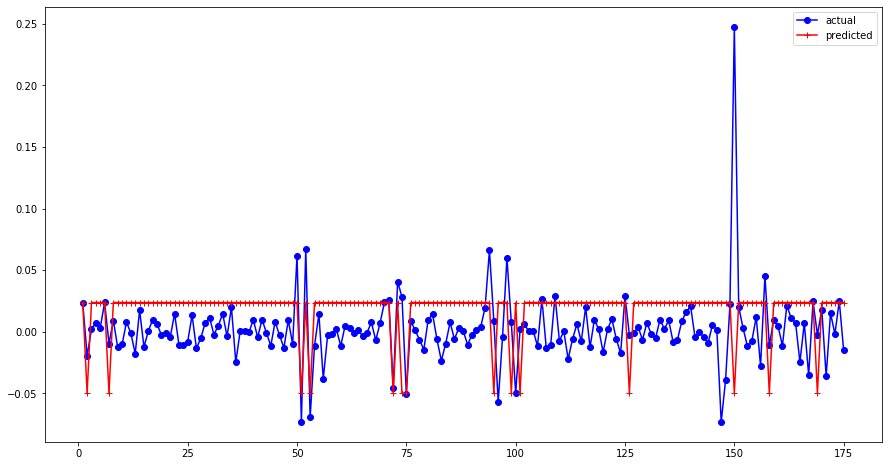

761.9100836679941


In [10]:
hpc = HpcPredictor('../원본 데이터/test_data/total_high_30_8_change.csv')
hpc.fit()
#hpc.predict_close_power_time(20, with_plot=True)
hpc.predict_change_time(175, with_plot=True)

2020-05-12 13:16:14,925 __main__     INFO     >>> Extracting Features
2020-05-12 13:16:14,925 __main__     INFO     >>> Extracting Features
2020-05-12 13:16:14,925 __main__     INFO     >>> Extracting Features
2020-05-12 13:16:14,925 __main__     INFO     >>> Extracting Features
2020-05-12 13:16:14,925 __main__     INFO     >>> Extracting Features
2020-05-12 13:16:14,928 __main__     INFO     Features extraction Completed <<<
2020-05-12 13:16:14,928 __main__     INFO     Features extraction Completed <<<
2020-05-12 13:16:14,928 __main__     INFO     Features extraction Completed <<<
2020-05-12 13:16:14,928 __main__     INFO     Features extraction Completed <<<
2020-05-12 13:16:14,928 __main__     INFO     Features extraction Completed <<<
100%|██████████████████████████████████████████████████████████████████████████████| 175/175 [1:43:16<00:00, 35.41s/it]


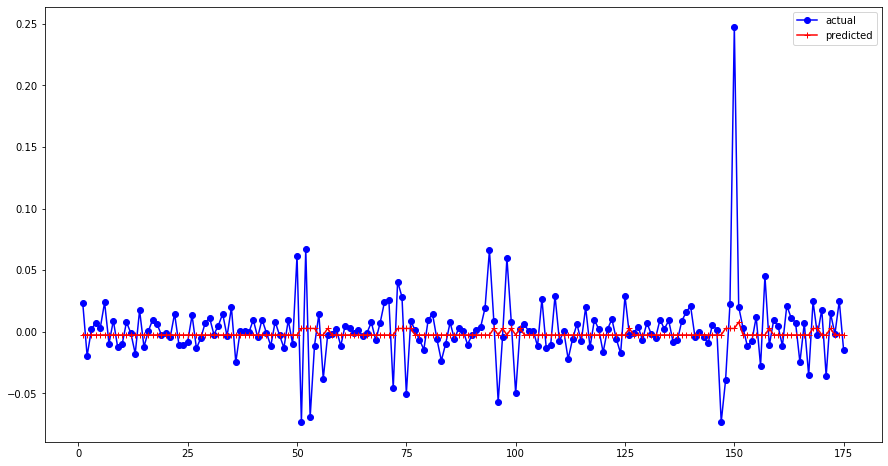

142.68420225146266


In [12]:
hpc = HpcPredictor('../원본 데이터/test_data/total_high_30_8_change.csv')
hpc.fit()
#hpc.predict_close_power_time(20, with_plot=True)
hpc.predict_change_time(175, with_plot=True)

2020-05-12 15:14:32,428 __main__     INFO     >>> Extracting Features
2020-05-12 15:14:32,428 __main__     INFO     >>> Extracting Features
2020-05-12 15:14:32,428 __main__     INFO     >>> Extracting Features
2020-05-12 15:14:32,428 __main__     INFO     >>> Extracting Features
2020-05-12 15:14:32,428 __main__     INFO     >>> Extracting Features
2020-05-12 15:14:32,428 __main__     INFO     >>> Extracting Features
2020-05-12 15:14:32,431 __main__     INFO     Features extraction Completed <<<
2020-05-12 15:14:32,431 __main__     INFO     Features extraction Completed <<<
2020-05-12 15:14:32,431 __main__     INFO     Features extraction Completed <<<
2020-05-12 15:14:32,431 __main__     INFO     Features extraction Completed <<<
2020-05-12 15:14:32,431 __main__     INFO     Features extraction Completed <<<
2020-05-12 15:14:32,431 __main__     INFO     Features extraction Completed <<<
100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [25:0

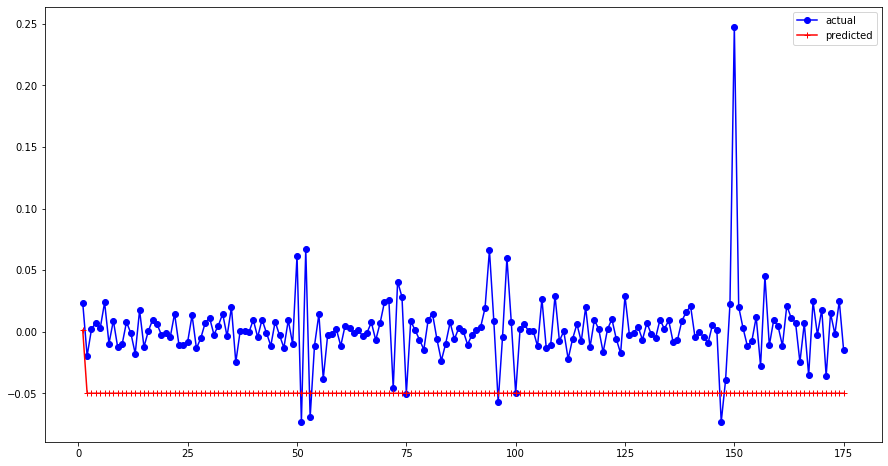

1556.3935765716972


In [15]:
hpc = HpcPredictor('../원본 데이터/test_data/total_high_30_8_change.csv')
hpc.fit()
#hpc.predict_close_power_time(20, with_plot=True)
hpc.predict_change_time(175, with_plot=True)

2020-05-12 16:13:27,630 __main__     INFO     >>> Extracting Features
2020-05-12 16:13:27,630 __main__     INFO     >>> Extracting Features
2020-05-12 16:13:27,630 __main__     INFO     >>> Extracting Features
2020-05-12 16:13:27,630 __main__     INFO     >>> Extracting Features
2020-05-12 16:13:27,630 __main__     INFO     >>> Extracting Features
2020-05-12 16:13:27,630 __main__     INFO     >>> Extracting Features
2020-05-12 16:13:27,630 __main__     INFO     >>> Extracting Features
2020-05-12 16:13:27,634 __main__     INFO     Features extraction Completed <<<
2020-05-12 16:13:27,634 __main__     INFO     Features extraction Completed <<<
2020-05-12 16:13:27,634 __main__     INFO     Features extraction Completed <<<
2020-05-12 16:13:27,634 __main__     INFO     Features extraction Completed <<<
2020-05-12 16:13:27,634 __main__     INFO     Features extraction Completed <<<
2020-05-12 16:13:27,634 __main__     INFO     Features extraction Completed <<<
2020-05-12 16:13:27,634 __main

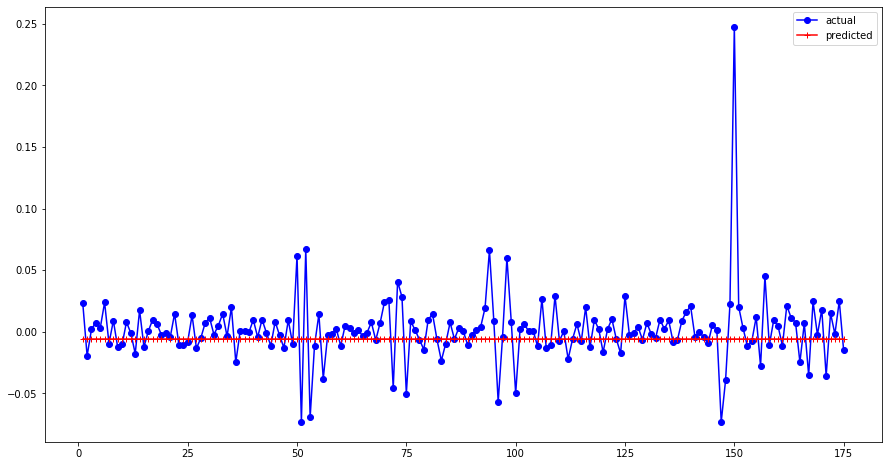

212.14762423070246


In [17]:
hpc = HpcPredictor('../원본 데이터/test_data/total_high_30_8_change.csv')
hpc.fit()
#hpc.predict_close_power_time(20, with_plot=True)
hpc.predict_change_time(175, with_plot=True)

2020-05-13 14:35:53,387 __main__     INFO     >>> Extracting Features
2020-05-13 14:35:53,388 __main__     INFO     Features extraction Completed <<<
100%|██████████| 50/50 [07:57<00:00,  9.55s/it]


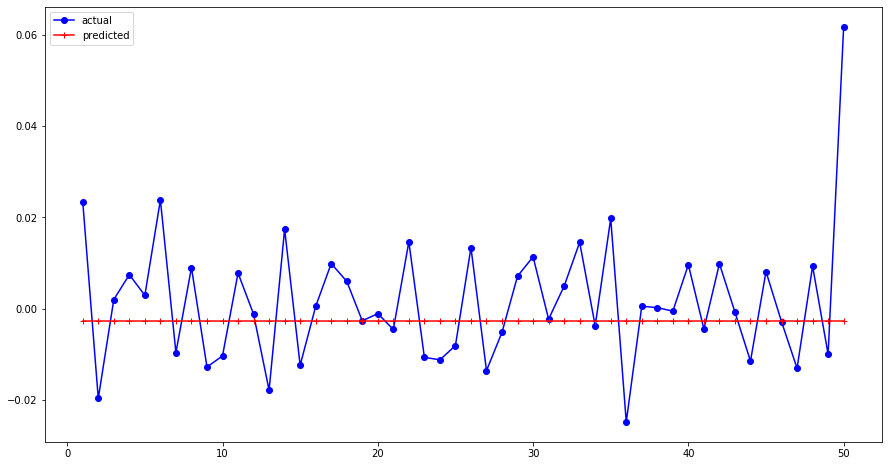

151.0764167852678


In [5]:
hpc = HpcPredictor('../원본 데이터/test_data/total_high_30_8_change.csv')
hpc.fit()
#hpc.predict_close_power_time(20, with_plot=True)
hpc.predict_change_time(50, with_plot=True)

In [ ]:
hpc = HpcPredictor('../원본 데이터/test_data/total_high_30_8_change.csv')
hpc.fit()
#hpc.predict_close_power_time(20, with_plot=True)
hpc.predict_change_time(50, with_plot=True)

2020-05-13 14:57:40,555 __main__     INFO     >>> Extracting Features
2020-05-13 14:57:40,555 __main__     INFO     >>> Extracting Features
2020-05-13 14:57:40,557 __main__     INFO     Features extraction Completed <<<
2020-05-13 14:57:40,557 __main__     INFO     Features extraction Completed <<<
 56%|█████▌    | 28/50 [42:02<35:58, 98.12s/it] 

In [3]:
class HpcPredictor(object):
    def __init__(self, file_name, latency = 4, test_size = 0.33, n_hidden_states = 7, n_mix = 2, 
                 n_steps_A = 10, n_steps_B = 10, n_steps_C = 10, n_steps_total_change = 30):
        
        self._init_logger()
        self.latency = latency
        #self.split_train_test_data(file_name, test_size)
        
        data = pd.read_csv(file_name)
        data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
        self.train_data = data
        data_t = pd.read_csv('../원본 데이터/test_data/15_low.csv')
        data_t = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
        self.test_data = data_t
        
        #self.hmm = GMMHMM(n_components=n_hidden_states, n_mix=n_mix)
        self.hmm = GaussianHMM(n_components=n_hidden_states)
        self._compute_all_possible_outcomes(n_steps_A, n_steps_B, n_steps_C, n_steps_total_change)
    
    def _init_logger(self):
        self._logger = logging.getLogger(__name__)
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
        handler.setFormatter(formatter)
        self._logger.addHandler(handler)
        self._logger.setLevel(logging.DEBUG)
    
    def split_train_test_data(self, file_name, test_size):
        data = pd.read_csv(file_name)
        data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
        train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)
        self.train_data = train_data
        self.test_data = test_data
    
    def _extract_features(data):        
        # write featrue
        feature_A = np.array(data['cpu/ref-cycles/_change'])
        feature_B = np.array(data['timer:hrtimer_cancel_change'])
        feature_C = np.array(data['sched:sched_stat_runtime_change'])
        total_change = np.array(data['total_change'])
        
        return np.column_stack((feature_A, feature_B, feature_C, total_change))
        
    def fit(self):
        self._logger.info('>>> Extracting Features')
        feature_vactor = HpcPredictor._extract_features(self.train_data)
        self._logger.info('Features extraction Completed <<<')
        self.hmm.fit(feature_vactor)
        
    def _compute_all_possible_outcomes(self, n_steps_A, n_steps_B, n_steps_C, n_steps_total_change):
        feature_A_range = np.linspace(-0.3, 0.5, n_steps_A)
        feature_B_range = np.linspace(-0.3, 0.5, n_steps_B)
        feature_C_range = np.linspace(-0.3, 0.5, n_steps_C)
        total_change_range = np.linspace(-0.3, 0.5, n_steps_total_change)
        
        self._possible_outcomes = np.array(list(itertools.product(feature_A_range, feature_B_range, 
                                                                  feature_C_range, total_change_range)))
        
    def _get_most_probable_outcome(self, index):
        previous_data_start_index = max(0, index - self.latency)
        previous_data_end_index = max(0, index) # ARRAY SLICE RANGE
        previous_data = self.test_data.iloc[previous_data_start_index : previous_data_end_index]
        previous_data_features = HpcPredictor._extract_features(previous_data)
             
        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack((previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))
        
        most_probable_outcome = self._possible_outcomes[np.argmax(outcome_score)]
        return most_probable_outcome
    
    def predict_close_power(self, index):
        
        total_power = self.test_data.iloc[index]['pre_total']
        _, _, _, predicted_total_change = self._get_most_probable_outcome(index)
        return total_power * (1 + predicted_total_change)
    
    def predict_close_change(self, index):
        
        _, _, _, predicted_total_change = self._get_most_probable_outcome(index)
        return predicted_total_change
    
    def predict_close_power_time(self, times, with_plot=False):
        predicted_close_power = []
        for index in tqdm(range(times)):
            predicted_close_power.append(self.predict_close_power(index))
        
        if with_plot:
            test_data = self.test_data[0:times]
            times = np.array(test_data['Unnamed: 0'])
            actual_total = test_data['total']
            
            fig = plt.figure(figsize=(10,8))
            
            axes = fig.add_subplot(111)
            axes.plot(times, actual_total, 'bo-', label='actual')
            axes.plot(times, predicted_close_power, 'r+-', label='predicted')
            
            plt.legend()
            plt.show()
            
        return predicted_close_power
    
    def predict_change_time(self, times, with_plot=False):
        predicted_change = []
        for index in tqdm(range(times)):
            predicted_change.append(self.predict_close_change(index))
            test_pr = self.predict_close_change(index+1)
            
        if with_plot:
            test_data = self.test_data[0:times]
            times = np.array(test_data['Unnamed: 0'])
            actual_total = test_data['total_change']
            
            mape = mean_absolute_percentage_error(actual_total, predicted_change)
            
            fig = plt.figure(figsize=(15,8))
            
            axes = fig.add_subplot(111)
            axes.plot(times, actual_total, 'bo-', label='actual')
            axes.plot(times, predicted_change, 'r+-', label='predicted')
            
            plt.legend()
            plt.show()
            print(mape)
            
        #return predicted_change
        return None

2020-05-12 11:19:14,577 __main__     INFO     >>> Extracting Features
2020-05-12 11:19:14,579 __main__     INFO     Features extraction Completed <<<
100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [08:20<00:00,  3.40s/it]


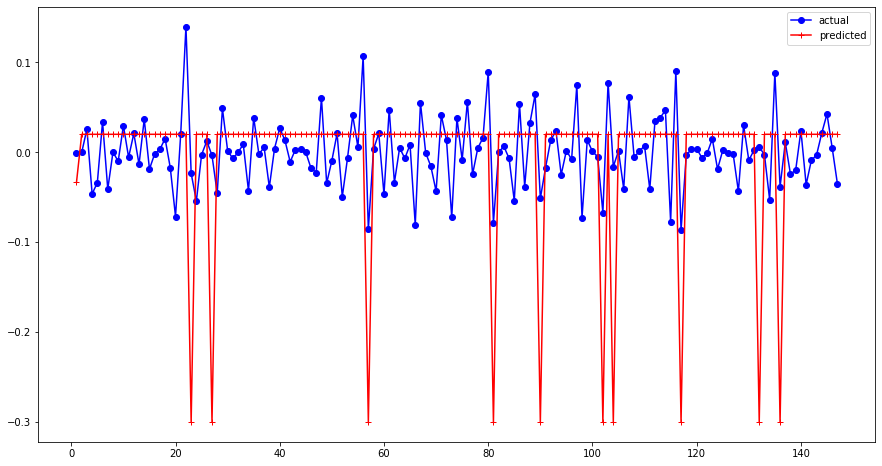

1048.2668564220194


In [4]:
hpc = HpcPredictor('../원본 데이터/test_data/total_low_30_8_change.csv')
hpc.fit()
#hpc.predict_close_power_time(20, with_plot=True)
hpc.predict_change_time(147, with_plot=True)